<a href="https://colab.research.google.com/github/ZohebAbai/Deep-Learning-Projects/blob/master/Tensorflow_Keras/01_TF_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression

We're going to try predict the cost of medical insurance for individuals based on a number of different parameters such as, age, sex, bmi, children, smoking_status and residential_region.

Steps covered:
1. Import Libraries
2. Downloading and View Dataset
3. Minimal EDA
4. Data Preprocessing --- Splitting, Normalization, One hot encoding and K-fold Cross Validation
5. Model Building and Training with L1 regularizers
6. Model Evaluation and Prediction


### Check the GPU

In [1]:
!nvidia-smi

Tue Jan 25 08:10:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import libraries

In [2]:
# Import required libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

print(tf.__version__)

2.7.0


## Downloading and View Dataset

In [3]:
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
#insurance.isnull().sum()

## Minimal EDA

Let's first visualize the histogram of medical costs.

Text(0.5, 1.0, 'Histogram of Charges')

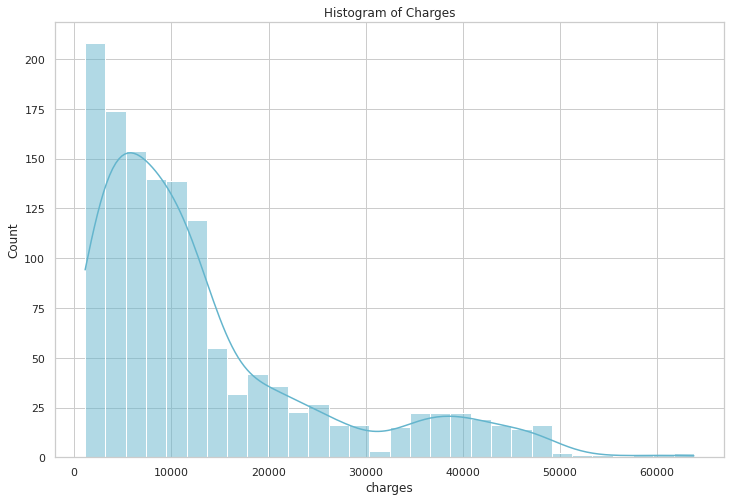

In [6]:
sns.set(style='whitegrid')
f, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sns.histplot(insurance['charges'], kde = True, color = 'c')
plt.title('Histogram of Charges')

This distribution is right-skewed. Let's guess that smoking might be most important factor on medical costs above region, age and bmi.

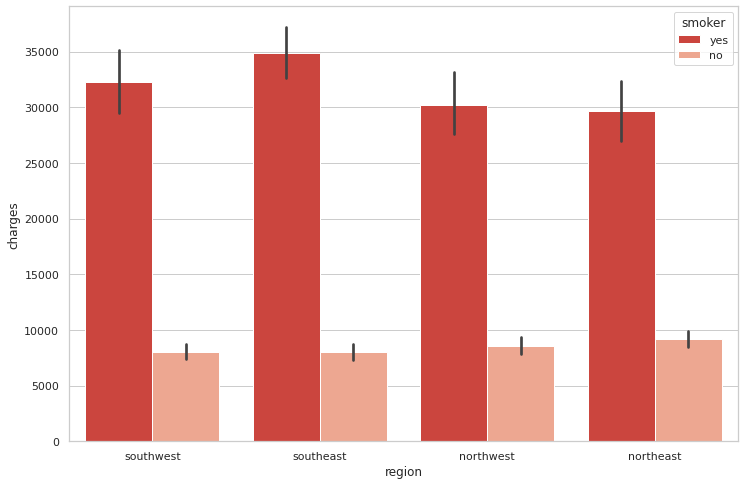

In [7]:
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.barplot(x = 'region', y = 'charges',
                 hue='smoker', data=insurance, palette='Reds_r')

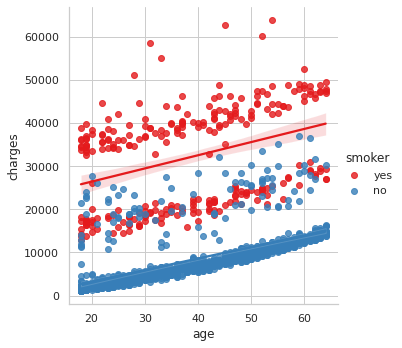

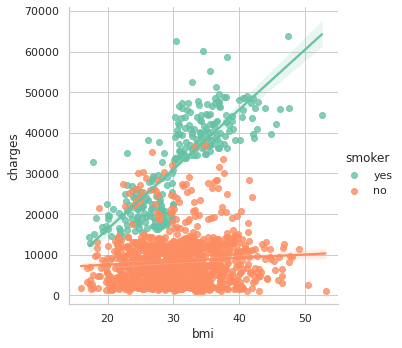

In [8]:
ax = sns.lmplot(x = 'age', y = 'charges', data=insurance, hue='smoker', palette='Set1')
ax = sns.lmplot(x = 'bmi', y = 'charges', data=insurance, hue='smoker', palette='Set2')

Our guess seems right!!

## Data Preprocessing --- Splitting, Normalization and One hot encoding

We will convert categorical variables (like the sex, smoker and region columns) into numerical variables using one-hot encoding. We'll also be normalizing the numerical columns to make sure they're all between a range.

In [9]:
# Create column transformer (this will help us preprocess our data)
ct = make_column_transformer(
    (StandardScaler(), ["age", "bmi", "children"]), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
)

# Create X & y
X = insurance.drop("charges", axis=1)
y = insurance["charges"]

# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

print(X_train_normal[0])

[-1.15786012 -0.68882801 -0.92785237  0.          1.          1.
  0.          0.          0.          1.          0.        ]


In [10]:
print(X_train_normal.shape)
print(X_test_normal.shape)

(1070, 11)
(268, 11)


**As the number of training samples are low, we shall use K-fold cross validation technique to reduce overfitting**

In [11]:
# Merge inputs and targets
inputs = np.concatenate((X_train_normal, X_test_normal), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
print(inputs[0])

[-1.15786012 -0.68882801 -0.92785237  0.          1.          1.
  0.          0.          0.          1.          0.        ]


In [12]:
# Define the K-fold Cross Validator
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)

## Model Building and Training

In [13]:
tf.random.set_seed(101)

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model training and evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    # Define the model architecture
    model = tf.keras.Sequential([
                                tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_normal.shape[1],)),
                                tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l1'),
                                tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l1'),
                                tf.keras.layers.Dense(1)
    ])
    # compile the model
    model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-02),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
    #model.summary()
    #checkpointer
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=f"bestmodel_{fold_no}.h5", verbose=0, mode='min',
                               save_best_only=True, monitor="loss")
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = model.fit(X_train_normal, y_train, epochs=50, callbacks=[checkpointer], verbose=1)

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
34/34 [==============================] - 1s 5ms/step - loss: 102.6319 - root_mean_squared_error: 18079.9121
Epoch 2/50
34/34 [==============================] - 0s 5ms/step - loss: 100.1153 - root_mean_squared_error: 18075.1582
Epoch 3/50
34/34 [==============================] - 0s 5ms/step - loss: 96.2697 - root_mean_squared_error: 17956.4629
Epoch 4/50
34/34 [==============================] - 0s 5ms/step - loss: 66.1531 - root_mean_squared_error: 15356.6836
Epoch 5/50
34/34 [==============================] - 0s 5ms/step - loss: 36.0011 - root_mean_squared_error: 12423.2363
Epoch 6/50
34/34 [==============================] - 0s 5ms/step - loss: 24.9015 - root_mean_squared_error: 10802.3877
Epoch 7/50
34/34 [==============================] - 0s 6ms/step - loss: 20.9218 - root_mean_squared_error: 9498.0801
Epoch 8/50
34/34 [==============================] - 0s 5ms/step - loss: 18.0

### Plot Training Loss History

In [14]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - RMSE: {acc_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> RMSE: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 10.149938583374023 - RMSE: 4558.2626953125
------------------------------------------------------------------------
> Fold 2 - Loss: 13.754504203796387 - RMSE: 6538.3095703125
------------------------------------------------------------------------
> Fold 3 - Loss: 8.347152709960938 - RMSE: 4995.1875
------------------------------------------------------------------------
> Fold 4 - Loss: 14.775846481323242 - RMSE: 6374.75634765625
------------------------------------------------------------------------
> Fold 5 - Loss: 17.07969093322754 - RMSE: 9290.2705078125
------------------------------------------------------------------------
> Fold 6 - Loss: 11.336735725402832 - RMSE: 5794.31494140625
------------------------------------------------------------------------
> Fold 7 - Loss: 12.462008476257324 - RMSE: 479

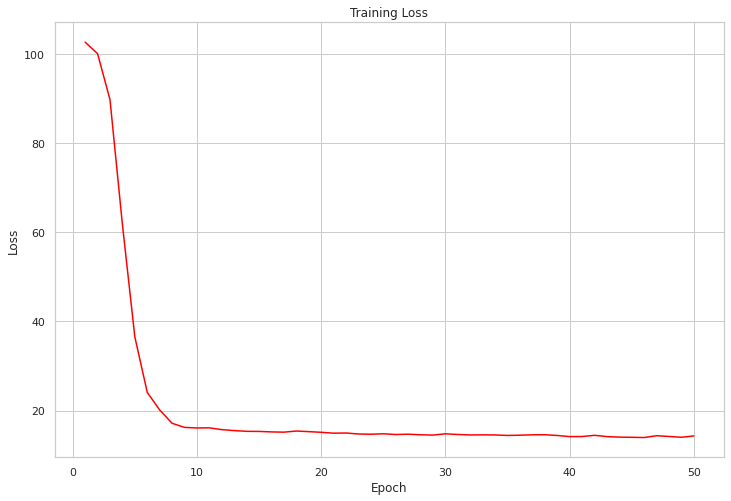

In [15]:
# summarize history for loss for last fold
plt.figure(figsize=(12,8))
plt.plot(range(1,len(history.history['loss'])+1), history.history['loss'], color="red")
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Model Evaluation and Prediction

In [22]:
bestmodel = tf.keras.models.load_model("bestmodel_1.h5")

# Evaluation for fold with lowest RMSE
score= bestmodel.evaluate(X_test_normal, y_test, verbose=0)
print("Minimal Training RMSE Score : ", score[1])

Minimal Training RMSE Score :  5044.384765625


In [23]:
y_pred = bestmodel.predict(tf.expand_dims(X_test_normal[17], axis=0))
print(f"Pred Value: {y_pred[0][0]} \nGround Truth: {np.array(y_test)[17]}")

Pred Value: 4387.416015625 
Ground Truth: 4391.652


**So Close!! Excellent!!!**

Let's visualize the deviation of predictions from complete test ground truth data.

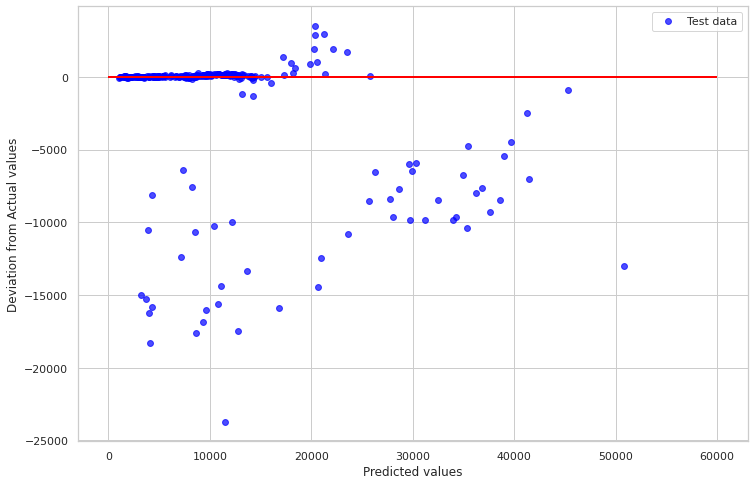

In [39]:
plt.figure(figsize=(12,8))
preds = bestmodel.predict(X_test_normal)
truth = np.asarray(y_test).reshape(-1,1)
plt.scatter(preds, preds - truth,
          c = 'blue', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Deviation from Actual values')
plt.legend(loc = 'upper right')
plt.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')
plt.show()

**Our model did not do well for higher values. For medical costs less than 15K it did excellent job.**